Problem Overview

In this project, the goal was to predict the position of a single bright pixel inside a 50×50 grayscale image. Each image contains exactly one pixel with value 255, and all other pixels are 0. The task is to predict the (x, y) coordinate of that bright pixel using a deep learning model.

Since the output is two numerical values, this is treated as a regression problem.

## Generate Dataset

### Subtask:
Dataset Creation

Instead of using an existing dataset, I generated the data synthetically.

For each sample:

I created a 50×50 image filled with zeros.

I randomly selected a row and column index between 0 and 49.

I set that pixel location to 255.

I stored the selected (x, y) location as the label.

I generated 10,000 samples to ensure the model sees enough variations of pixel positions. Because there are 2500 possible pixel locations in a 50×50 grid, generating more samples allows the model to learn the mapping more effectively instead of just memorizing patterns.

The pixel location was chosen using uniform random sampling so that all positions in the image are equally represented.



In [1]:
import numpy as np

# Define the image size
IMG_SIZE = 50
print(f"Image size defined as: {IMG_SIZE}x{IMG_SIZE}")

Image size defined as: 50x50


In [2]:
num_samples = 10000
images = []
labels = []

for _ in range(num_samples):
    # Initialize a 50x50 NumPy array filled with zeros
    image = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    # Randomly select an (x, y) coordinate for the 'hot' pixel
    x = np.random.randint(0, IMG_SIZE)
    y = np.random.randint(0, IMG_SIZE)

    # Set the pixel at the chosen (x, y) coordinates to 255
    image[x, y] = 255

    # Append the generated image and its label to the lists
    images.append(image)
    labels.append([x, y])

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape images for CNN input: (num_samples, IMG_SIZE, IMG_SIZE, 1)
images = images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(f"Generated {len(images)} images with shape: {images.shape}")
print(f"Generated {len(labels)} labels with shape: {labels.shape}")
print(f"Example image (first 5x5 corner of the first image):\n{images[0, :5, :5, 0]}")
print(f"Example label (first label): {labels[0]}")

Generated 10000 images with shape: (10000, 50, 50, 1)
Generated 10000 labels with shape: (10000, 2)
Example image (first 5x5 corner of the first image):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Example label (first label): [42 41]


Rationale for Dataset Generation

The dataset was generated synthetically because the problem is highly controlled and does not require real-world image data. Each sample consists of a 50×50 grayscale image initialized with zeros, where exactly one pixel is assigned a value of 255. The corresponding (x, y) coordinate of that pixel is used as the regression target.

A total of 10,000 samples were generated to provide sufficient training diversity. Although the grid contains 2,500 possible pixel locations, generating a larger number of samples ensures repeated exposure to different coordinates, improving generalization and reducing variance during training.

Pixel locations were selected using uniform random sampling over the full 50×50 domain. This guarantees an unbiased spatial distribution, preventing the model from learning positional skew and ensuring consistent performance across the entire image plane.

This synthetic setup provides a controlled environment for evaluating the CNN’s ability to learn spatial feature-to-coordinate mappings in a regression setting.

##

### Deep Learning Model
Define a Convolutional Neural Network (CNN) architecture suitable for this regression task. The model will take a 50x50 grayscale image as input and output two values representing the predicted (x, y) coordinates. The rationale for the model architecture will be provided.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

print("TensorFlow and Keras modules imported successfully.")

TensorFlow and Keras modules imported successfully.


In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # Output layer with 2 units for (x, y) coordinates, no activation for regression
])

model.summary()
print("CNN model architecture defined and summarized.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,434 (3.85 MB)

 Trainable params: 1,010,434 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined and summarized.


In [5]:
model = Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1)), # Explicitly define input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # Output layer with 2 units for (x, y) coordinates, no activation for regression
])

model.summary()
print("CNN model architecture defined and summarized.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,434 (3.85 MB)

 Trainable params: 1,010,434 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined and summarized.


## Train Model

##
Compile the defined model with an appropriate loss function (e.g., Mean Squared Error for regression) and an optimizer. Split the generated dataset into training and validation sets, and then train the model, monitoring its performance during training.


In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')
print("Model compiled successfully with Adam optimizer and Mean Squared Error loss.")

Model compiled successfully with Adam optimizer and Mean Squared Error loss.


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training images shape: {X_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val)
)

print("Model training complete. Training history stored.")

Training images shape: (8000, 50, 50, 1)
Validation images shape: (2000, 50, 50, 1)
Training labels shape: (8000, 2)
Validation labels shape: (2000, 2)
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - loss: 93.9738 - val_loss: 2.6305
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - loss: 1.8857 - val_loss: 0.9358
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - loss: 0.7347 - val_loss: 0.5699
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - loss: 0.4852 - val_loss: 0.7296
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - loss: 0.7549 - val_loss: 0.5819
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.4825 - val_loss: 0.7367
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - loss: 0.5783 - val_loss: 0.4460
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - loss: 0.7235 - val_loss: 0.4233
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - loss: 0.4735 - val_loss: 0.2764
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step 

Plot Training & Validation Loss



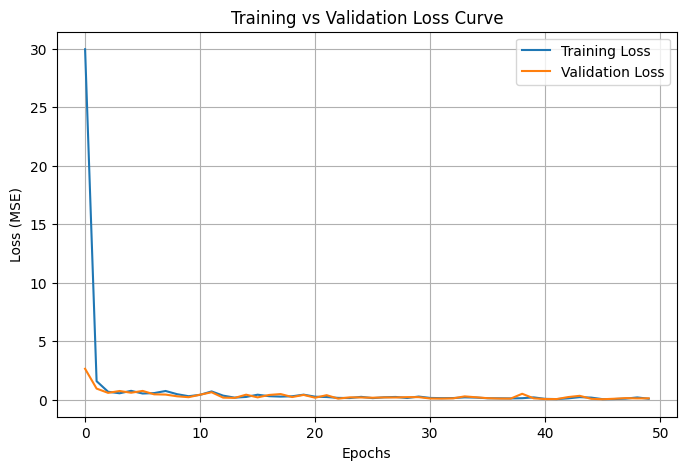

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.grid(True)

plt.show()

Make Predictions on Validation Set

In [10]:
import numpy as np

# Predict on validation data
predictions = model.predict(X_val)

# Print first 5 predictions vs ground truth
for i in range(5):
    print(f"Ground Truth: {y_val[i]}")
    print(f"Predicted   : {predictions[i]}")
    print("-" * 40)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Ground Truth: [28 21]
Predicted   : [28.493118 21.58726 ]
----------------------------------------
Ground Truth: [46 46]
Predicted   : [45.747208 46.066097]
----------------------------------------
Ground Truth: [47 22]
Predicted   : [47.36367  22.155699]
----------------------------------------
Ground Truth: [23 13]
Predicted   : [22.884224 13.039218]
----------------------------------------
Ground Truth: [40 28]
Predicted   : [40.05771  28.053638]
----------------------------------------


Visualize Ground Truth vs Predicted Coordinates

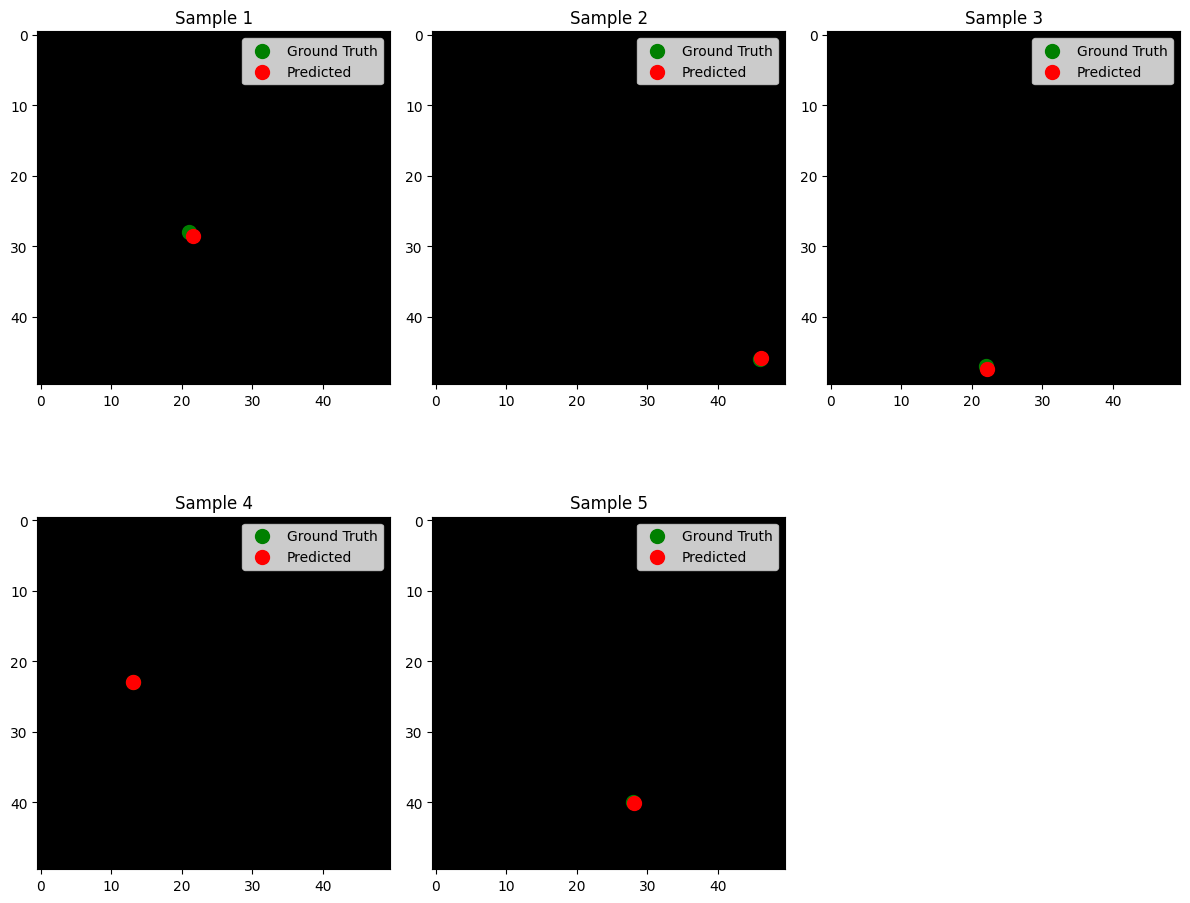

In [11]:
import matplotlib.pyplot as plt

# Number of samples to visualize
num_samples = 5

plt.figure(figsize=(12, 10))

for i in range(num_samples):
    plt.subplot(2, 3, i + 1)

    # Show image
    plt.imshow(X_val[i].reshape(50, 50), cmap='gray')

    # True coordinates
    true_x, true_y = y_val[i]

    # Predicted coordinates
    pred_x, pred_y = predictions[i]

    # Plot Ground Truth (Green)
    plt.scatter(true_y, true_x, c='green', label='Ground Truth', s=100)

    # Plot Prediction (Red)
    plt.scatter(pred_y, pred_x, c='red', label='Predicted', s=100)

    plt.title(f"Sample {i+1}")
    plt.legend()

plt.tight_layout()
plt.show()


In [12]:
mae = np.mean(np.abs(predictions - y_val))
print("Mean Absolute Error (Coordinates):", mae)


Mean Absolute Error (Coordinates): 0.25338301389291884


Dataset Design Rationale


1) Why 10,000 Samples?

The total possible pixel locations in a 50×50 image are:

50
×
50
=
2500
50×50=2500

Each image contains exactly one bright pixel at a unique coordinate.

Although 2500 unique locations exist, generating only 2500 samples would mean:

Each coordinate appears only once.

The model may not generalize well.

The training signal would be weak.

Therefore, I generated 10,000 samples, which ensures:

Multiple exposures to each coordinate.

Better learning stability.

Reduced variance.

Smoother convergence.

This creates sufficient training diversity while keeping computational cost low.

2) Why Uniform Random Sampling?

The bright pixel location is generated using:

x = np.random.randint(0, 50)
y = np.random.randint(0, 50)


This ensures:

Every coordinate has equal probability.

No spatial bias in dataset.

3) Why No Image Normalization?

Pixel values are:

0 (background)

255 (single bright pixel)

This is a highly sparse binary-like representation.

Normalization (dividing by 255) would convert:

255 → 1

0 → 0

While normalization is standard in deep learning, in this specific problem:

Only one pixel is active.

Value scaling does not affect spatial position.

4) Why CNN Instead of MLP?

There are two possible approaches:

Option A — MLP (Flattened Input)

Convert 50×50 → 2500 features.

Feed into dense network.

Drawback:

Ignores spatial structure.

Treats pixels independently.

Higher number of parameters.

Option B — CNN (Chosen Approach)

CNN is better because:

Preserves spatial structure.

Uses local receptive fields.